FER Model Testing & Evaluation

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-10-14 06:50:05.704245: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-14 06:50:05.934112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 06:50:08.692418: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


CONFIGURATION

In [2]:
DATA_DIR = "../../../Data/images"
TEST_DIR = os.path.join(DATA_DIR, "validation")
MODEL_DIR = "../../../models"
MODEL_TAG_1 = "mini_xception_fer_best"
MODEL_TAG_2 = "mini_xception_fer"

MODEL_PATH = os.path.join(MODEL_DIR, f"{MODEL_TAG_1}.keras")
CLASSMAP_PATH = os.path.join(MODEL_DIR, f"{MODEL_TAG_2}_classes.json")

IMG_SIZE = 48
BATCH_SIZE = 32

print("=" * 60)
print("FER Model Testing")
print("=" * 60)
print(f"Test directory: {TEST_DIR}")
print(f"Model path: {MODEL_PATH}")
print()

FER Model Testing
Test directory: ../../../Data/images/validation
Model path: ../../../models/mini_xception_fer_best.keras



LOAD MODEL & CLASS MAPPING

In [3]:
print("Loading model...")
model = keras.models.load_model(MODEL_PATH)
print("✓ Model loaded successfully!")

# Load class mapping
with open(CLASSMAP_PATH, "r") as f:
    class_map = json.load(f)

# Create ordered list of class names
idx_to_class = {v: k for k, v in class_map.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(f"Classes: {class_names}")
print()

Loading model...


2025-10-14 06:50:27.113873: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✓ Model loaded successfully!
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']



CREATE TEST DATA GENERATOR

In [4]:
print("Creating test data generator...")
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False  # Important: keep order for evaluation
)

print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {test_generator.num_classes}")
print()

Creating test data generator...
Found 7066 images belonging to 7 classes.
Test samples: 7066
Number of classes: 7



EVALUATE MODEL

In [5]:
print("Evaluating model on test set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print("=" * 60)
print(f"Test Loss:     {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.6f} ({test_acc*100:.2f}%)")
print("=" * 60)
print()

Evaluating model on test set...


/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss:     1.130289
Test Accuracy: 0.571469 (57.15%)



GENERATE PREDICTIONS

In [6]:
print("Generating predictions...")
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print(f"Predictions generated: {len(y_pred)}")
print()

Generating predictions...
Predictions generated: 7066



CLASSIFICATION REPORT

In [7]:
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print()

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.4457    0.4833    0.4638       960
     disgust     1.0000    0.0180    0.0354       111
        fear     0.4644    0.2240    0.3022      1018
       happy     0.7521    0.8395    0.7934      1825
     neutral     0.4689    0.6809    0.5553      1216
         sad     0.4599    0.3828    0.4178      1139
    surprise     0.7017    0.6876    0.6946       797

    accuracy                         0.5715      7066
   macro avg     0.6132    0.4737    0.4661      7066
weighted avg     0.5714    0.5715    0.5533      7066




CONFUSION MATRIX

Generating confusion matrix...


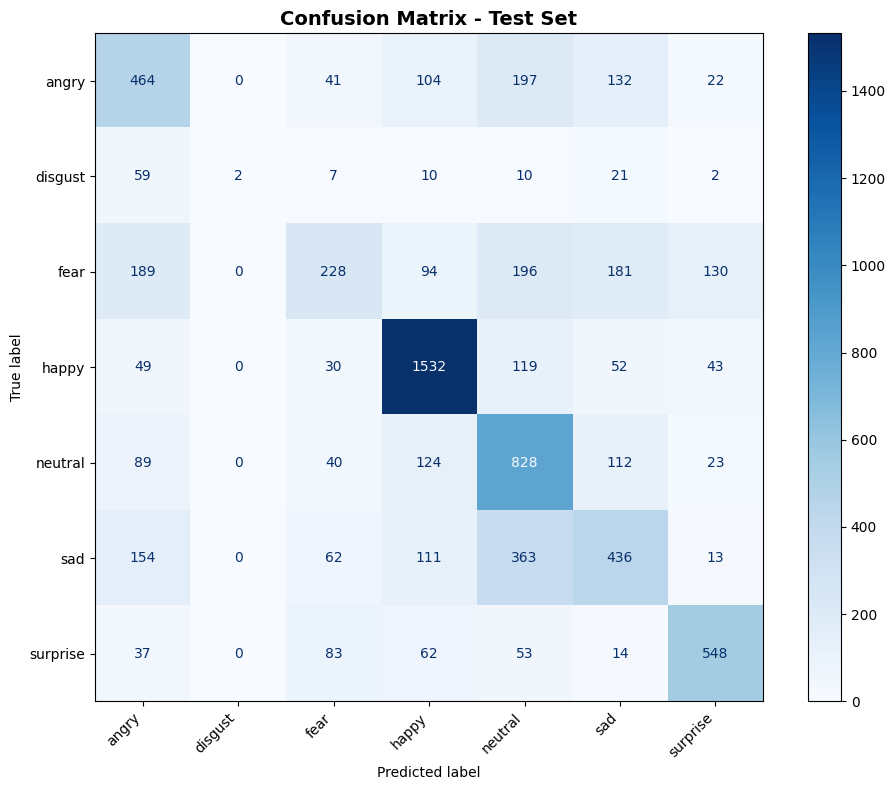

In [8]:
print("Generating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format='d')
plt.title("Confusion Matrix - Test Set", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

PER-CLASS ACCURACY


Calculating per-class accuracy...
angry       : 0.4833 (48.33%)
disgust     : 0.0180 (1.80%)
fear        : 0.2240 (22.40%)
happy       : 0.8395 (83.95%)
neutral     : 0.6809 (68.09%)
sad         : 0.3828 (38.28%)
surprise    : 0.6876 (68.76%)



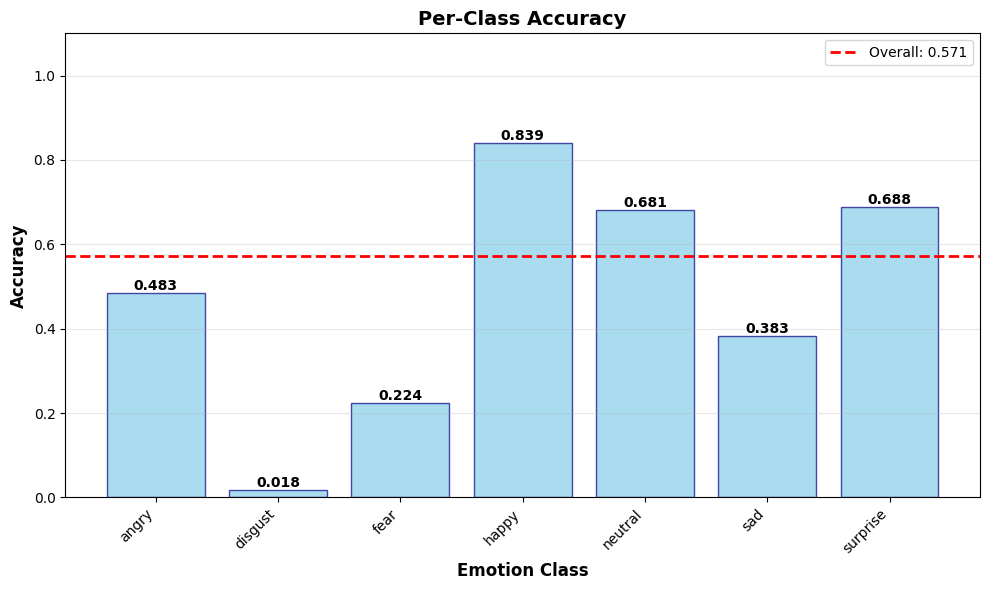

In [9]:
print("\nCalculating per-class accuracy...")
class_accuracies = []

for i, class_name in enumerate(class_names):
    class_mask = (y_true == i)
    if class_mask.sum() > 0:
        class_acc = (y_pred[class_mask] == y_true[class_mask]).mean()
        class_accuracies.append(class_acc)
        print(f"{class_name:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)")
    else:
        class_accuracies.append(0)
        print(f"{class_name:12s}: No samples")

print()

# Plot per-class accuracy
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_names, class_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim(0, 1.1)
ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax.set_xlabel("Emotion Class", fontsize=12, fontweight='bold')
ax.set_title("Per-Class Accuracy", fontsize=14, fontweight='bold')
ax.axhline(y=test_acc, color='r', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.3f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SAMPLE DISTRIBUTION


Test Set Distribution:
----------------------------------------
angry       :  960 samples (13.6%)
disgust     :  111 samples (1.6%)
fear        : 1018 samples (14.4%)
happy       : 1825 samples (25.8%)
neutral     : 1216 samples (17.2%)
sad         : 1139 samples (16.1%)
surprise    :  797 samples (11.3%)
----------------------------------------
Total       : 7066 samples



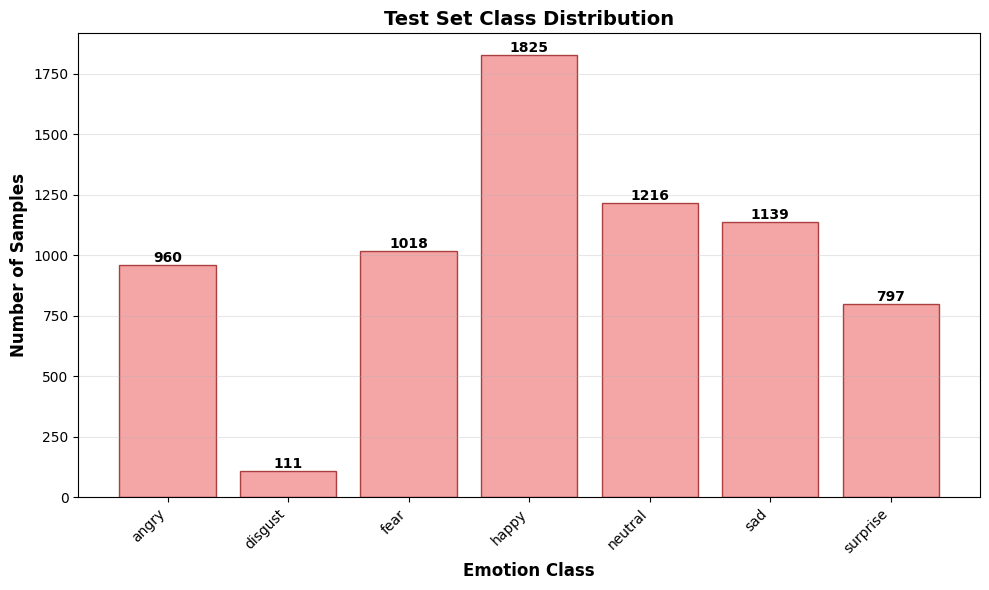

In [10]:
from collections import Counter
class_distribution = Counter(y_true)

print("\nTest Set Distribution:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    count = class_distribution[i]
    percentage = (count / len(y_true)) * 100
    print(f"{class_name:12s}: {count:4d} samples ({percentage:.1f}%)")

print("-" * 40)
print(f"{'Total':12s}: {len(y_true):4d} samples")
print()

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 6))
counts = [class_distribution[i] for i in range(len(class_names))]
bars = ax.bar(class_names, counts, color='lightcoral', edgecolor='darkred', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_xlabel("Emotion Class", fontsize=12, fontweight='bold')
ax.set_title("Test Set Class Distribution", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TOP MISCLASSIFICATIONS

In [11]:
print("\nTop 5 Misclassifications:")
print("-" * 60)

misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i, j]))

misclassifications.sort(key=lambda x: x[2], reverse=True)

for idx, (true_label, pred_label, count) in enumerate(misclassifications[:5], 1):
    print(f"{idx}. {true_label} → {pred_label}: {count} times")

print("-" * 60)


Top 5 Misclassifications:
------------------------------------------------------------
1. sad → neutral: 363 times
2. angry → neutral: 197 times
3. fear → neutral: 196 times
4. fear → angry: 189 times
5. fear → sad: 181 times
------------------------------------------------------------


PREDICTION CONFIDENCE ANALYSIS


Prediction Confidence Analysis:
------------------------------------------------------------
Correct predictions:   Avg confidence = 0.6899
Incorrect predictions: Avg confidence = 0.4700



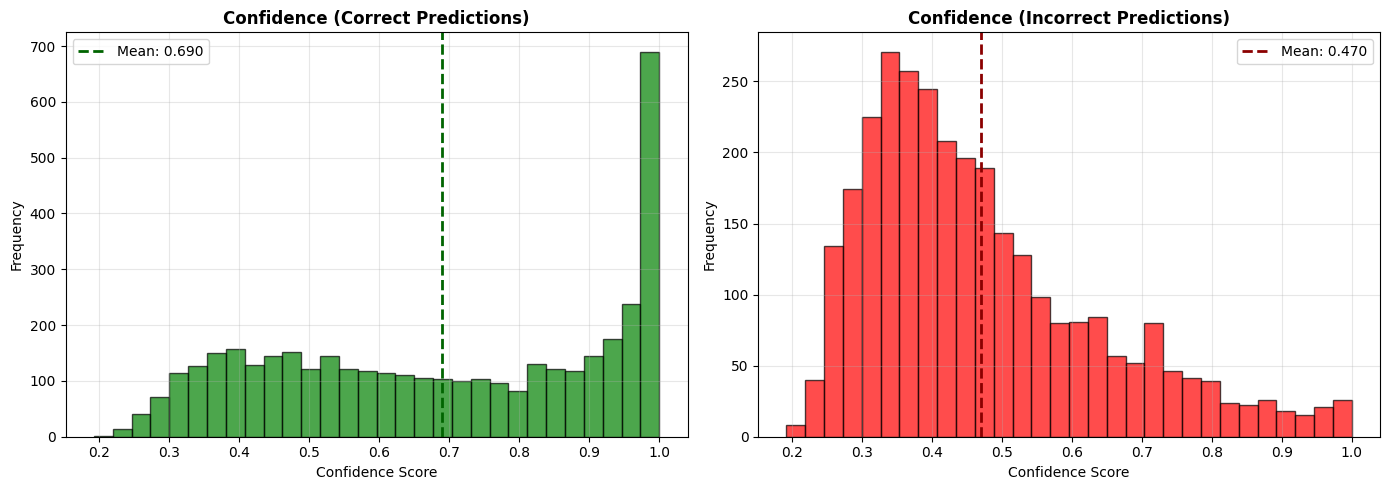

In [12]:
print("\nPrediction Confidence Analysis:")
print("-" * 60)

# Max probabilities for each prediction
max_probs = np.max(y_pred_probs, axis=1)

correct_mask = (y_pred == y_true)
correct_confidences = max_probs[correct_mask]
incorrect_confidences = max_probs[~correct_mask]

print(f"Correct predictions:   Avg confidence = {correct_confidences.mean():.4f}")
print(f"Incorrect predictions: Avg confidence = {incorrect_confidences.mean():.4f}")
print()

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(correct_confidences, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title("Confidence (Correct Predictions)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Confidence Score")
axes[0].set_ylabel("Frequency")
axes[0].axvline(correct_confidences.mean(), color='darkgreen', linestyle='--', 
                linewidth=2, label=f'Mean: {correct_confidences.mean():.3f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(incorrect_confidences, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title("Confidence (Incorrect Predictions)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Confidence Score")
axes[1].set_ylabel("Frequency")
axes[1].axvline(incorrect_confidences.mean(), color='darkred', linestyle='--', 
                linewidth=2, label=f'Mean: {incorrect_confidences.mean():.3f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

SUMMARY

In [14]:
print("\n" + "=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)
print(f"Model:           {MODEL_TAG_1}")
print(f"Test Samples:    {len(y_true)}")
print(f"Test Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:       {test_loss:.6f}")
print(f"Best Class:      {class_names[np.argmax(class_accuracies)]} ({max(class_accuracies):.4f})")
print(f"Worst Class:     {class_names[np.argmin(class_accuracies)]} ({min(class_accuracies):.4f})")
print("=" * 60)
print("\n✓ Evaluation complete!")


EVALUATION SUMMARY
Model:           mini_xception_fer_best
Test Samples:    7066
Test Accuracy:   0.5715 (57.15%)
Test Loss:       1.130289
Best Class:      happy (0.8395)
Worst Class:     disgust (0.0180)

✓ Evaluation complete!
